**Sprawozdanie z lab8**
*Piotr Piotrak, 82667*

In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!pip install ipython-autotime
%load_ext autotime

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-oadyvl38
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-oadyvl38
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=2705ed44d39129ee5079cea1adae3384a5b3d50d82a9f9cb2f6ee46a78f20532
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh6vkxni/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

Wersja na GPU:

In [2]:
%%cu
#include<stdio.h>
#include <time.h>
#include <unistd.h>
#define DIM 6000
struct cuComplex{
    float r;
    float i;
    //cuComplex(floata,floatb):r(a),i(b){}
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i;}
    __device__ cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    __device__ cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};

__device__ int mandelbrot(int x, int y) {
    const float scale = 1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + c;
        if (a.magnitude2()>1000) return 0;
    }
    return 1;
}

__global__ void kernel(unsigned char *ptr) {
    // Odwzorowanie z blockIdx na współrzędne piksela
    int x=blockIdx.x;
    int y=blockIdx.y;
    int offset=x+y*gridDim.x;

    // Obliczenie wartości dla tego punktu
    int mValue=mandelbrot(x,y);
    ptr[offset*4+0]=255*mValue;
    ptr[offset*4+1]=0;
    ptr[offset*4+2]=0;
    ptr[offset*4+3]=255;
}

// Dalsze elementy programu pozwalają na zapisanie Fraktala do pliku tekstowego
struct DataBlock{
    unsigned char *dev_bitmap;
};

// wypisywanie zawartości bitmapy
void wypisz_RGB_fraktal(unsigned char *ptr) {
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset = x + y * DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}

void save_to_file(unsigned char *ptr) {
    FILE *fp = fopen("Fraktal_GPU.txt","w");
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset = x + y * DIM;
            fprintf(fp, "\n%d %d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
    fclose(fp);
}
int main(void){
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;
    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap=dev_bitmap;
    dim3 grid(DIM, DIM);
    kernel<<<grid,1>>>(dev_bitmap);
    cudaMemcpy(bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
    cudaFree(dev_bitmap);
    save_to_file(bitmap);
}


time: 10.5 s (started: 2023-01-26 17:50:16 +00:00)


Ten kod jest programem napisanym w języku C z wykorzystaniem CUDA, biblioteki umożliwiającej programowanie rdzeni graficznych (GPU) przez programistów. Kod ten generuje fraktal o nazwie Mandelbrot i zapisuje go do pliku tekstowego.

W programie zdefiniowano strukturę danych cuComplex, która reprezentuje liczbę złożoną w postaci rzeczywistej i urojonej. Struktura ta zawiera kilka metod, takie jak magnitude2, operator*, operator+ itp.

Funkcja mandelbrot jest deklarowana jako __device__ i przyjmuje 2 argumenty int x i y. Funkcja ta liczy punkt fraktalu dla danego x i y.

Kernel jest funkcją __global__, która jest wywoływana przez GPU. Przyjmuje ona jeden argument, wskaźnik na tablicę unsigned char. W funkcji kernel zostaje zdefiniowane położenie bloku, a następnie obliczana jest wartość dla tego punktu za pomocą funkcji mandelbrot.

W main, alokowana jest pamięć dla bitmapy i uruchamiany jest kernel z odpowiednią liczbą bloków i wątków. Następnie bitmapa jest kopiowana z urządzenia do hosta i zapisywana do pliku tekstowego.

Wersja na CPU:

In [3]:
%%cu
#include<stdio.h>
#define DIM 6000
struct cuComplex{
    float r;
    float i;
    cuComplex(float a,float b):r(a),i(b){}
    float magnitude2(void){ return r*r+i*i;}
    cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};

int mandelbrot(int x, int y) {
    const float scale = 1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex c(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + c;
        if (a.magnitude2()>1000) return 0;
    }
    return 1;
}

void kernel(unsigned char *ptr) {
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset=x+y*DIM;
            int mValue=mandelbrot(x,y);
            ptr[offset*4+0]=255*mValue;
            ptr[offset*4+1]=0;
            ptr[offset*4+2]=0;
            ptr[offset*4+3]=255;
        }
    }
}

// Dalsze elementy programu pozwalają na zapisanie Fraktala do pliku tekstowego
struct DataBlock{
    unsigned char *dev_bitmap;
};

// wypisywanie zawartości bitmapy
void wypisz_RGB_fraktal(unsigned char *ptr) {
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset = x + y * DIM;
            printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
}

void save_to_file(unsigned char *ptr) {
    FILE *fp = fopen("Fraktal_GPU.txt","w");
    for (int y = 0; y < DIM; y++) {
        for (int x = 0; x < DIM; x++) {
            int offset = x + y * DIM;
            fprintf(fp, "\n%d %d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
        }
    }
    fclose(fp);
}
int main(void){
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
    save_to_file(bitmap);
}


time: 51.1 s (started: 2023-01-26 17:50:27 +00:00)


Początkowo kod zawiera definicję struktury cuComplex, która reprezentuje liczbę zespoloną z dwoma składowymi: rzeczywistą i urojoną. Struktura ta posiada kilka metod, takie jak magnitude2, operator * i operator +, które służą do obliczania mocy, mnożenia i dodawania liczb zespolonych.

Następnie kod zawiera funkcję mandelbrot, która jest sercem tego programu. Funkcja ta przyjmuje dwa argumenty: x i y, które reprezentują pozycję punktu na ekranie. Funkcja ta tworzy liczbę zespoloną c na podstawie pozycji punktu na ekranie i następnie iteruje przez 200 kroków, wykonując operacje matematyczne na liczbie zespolonej a. Jeśli wartość mocy liczby zespolonej a przekroczy 1000, funkcja zwraca 0, w przeciwnym razie zwraca 1.

Kolejnym krokiem jest funkcja kernel, która jest wywoływana w głównej funkcji main. Funkcja ta przyjmuje wskaźnik na tablice unsigned char, która jest używana do przechowywania bitmapy obrazu fraktala. W funkcji kernel, pętla jest iterowana przez wszystkie punkty na ekranie i dla każdego punktu, jego wartość fraktala jest obliczana przy użyciu funkcji mandelbrot. Następnie wartość fraktala jest zapisywana w bitmapie za pomocą offsetu.

Kod zawiera również funkcję wypisz_RGB_fraktal, która pozwala na wypisanie zawartości bitmapy na ekranie. I funkcja save_to_file, która pozwala na zapisanie bitmapy do pliku tekstowego o nazwie "Fraktal_GPU.txt".

W głównej funkcji main, jest tworzony blok pamięci data, wskaźnik bitmap oraz zmienna image_size, która przechowuje rozmiar obrazu w pikselach. Następnie jest wywoływana funkcja kernel, która generuje fraktal na podstawie danych wejściowych i zapisuje go w bitmapie. Na końcu, bitmapa jest zapisywana do pliku tekstowego za pomocą funkcji save_to_file.

Ten kod to dobry przykład jak wykorzystać CUDA C do obliczeń na GPU.

## **Wykresy:**

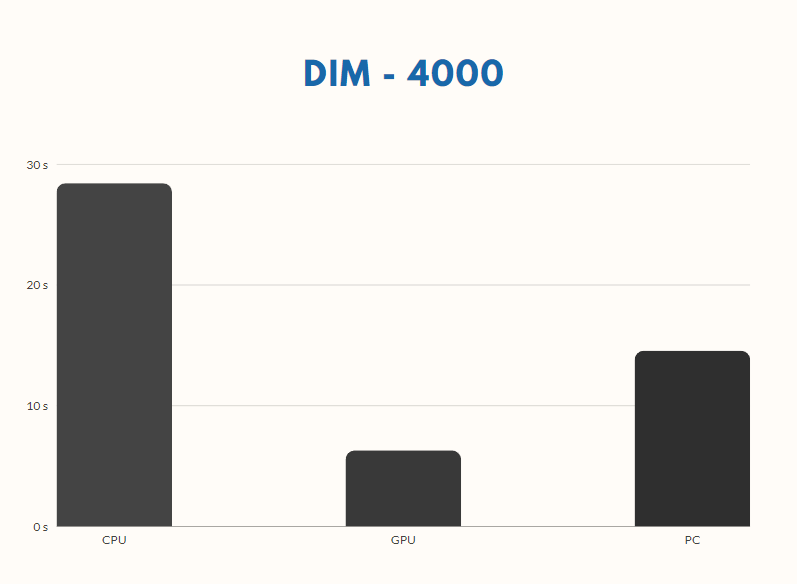

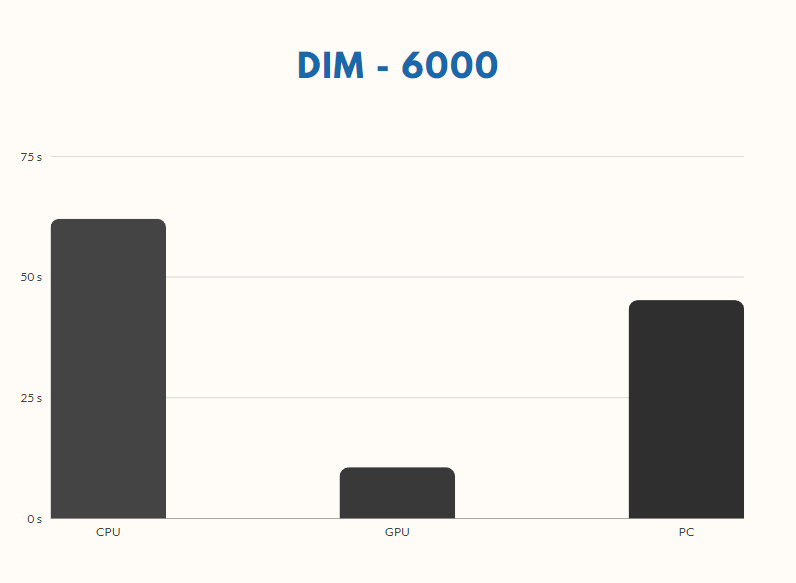